# Boston Dataset & Causal Inference Playground

### Playing with Causal Discovery Toolbox (cdt) package

Load (and prepare) [Boston dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)

- More info: https://deepblue.lib.umich.edu/bitstream/handle/2027.42/22636/0000186.pdf?sequence=1&isAllowed=y
- Tutorial on [Causal Discovery Toolbox](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/tutorial.html)

In [1]:
from sklearn.datasets import load_boston
import pandas as pd

data = load_boston()

df_features = pd.DataFrame(data['data'], columns=data.feature_names)
df_target = pd.DataFrame(data['target'],columns=['MEDV'])
df = df_features.join(df_target)

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Step 1: Generate undirected graph with HSICLasso method

In [2]:
#import cdt
#cdt.SETTINGS.GPU = 0
from cdt.independence.graph import HSICLasso,Glasso,DecisionTreeRegression

obj = HSICLasso()
#obj = Glasso()
#obj = DecisionTreeRegression()
ugraph = obj.predict(df) 

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


Step 1b: Plot undirected graph with networkx

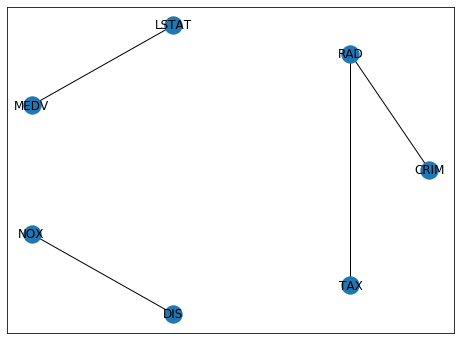

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
graph = ugraph

# Sort alphabetically, to keep same circular layout
sorted_graph = nx.Graph()
sorted_graph.add_edges_from(sorted(graph.edges()))
pos = nx.drawing.layout.circular_layout(sorted_graph)

plt.figure(0,figsize=(8,6)) 
nx.draw_networkx(sorted_graph,pos)

plt.show()

Step 2: Transform undirected graph into directed graph with ANM method

In [4]:
from cdt.causality.pairwise import ANM
obj = ANM()
graph = obj.orient_graph(df_features.join(df_target), nx.DiGraph(ugraph))

Step 2b: Plot directed graph

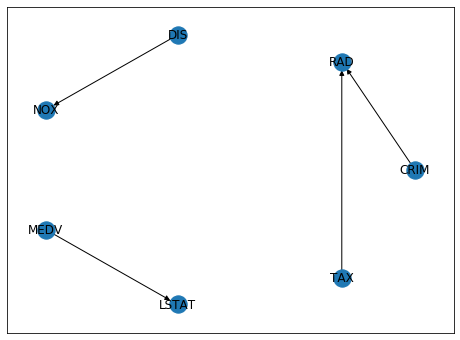

In [5]:
sorted_graph = nx.DiGraph()
sorted_graph.add_edges_from(sorted(graph.edges()))
pos = nx.drawing.layout.circular_layout(sorted_graph)

plt.figure(0,figsize=(8,6)) 
nx.draw_networkx(sorted_graph,pos)

plt.show()


Discussion:
- NOX as caused by DIS, makes sense
- LSTAT as caused by MEDV, hard to believe, or arguable at least
- RAD as caused by TAX, also hard to believe
- RAD as caused by CRIM, probably wrong

Let's compare step 2) with other methods that extend `cdt.causality.pairwise.model.PairwiseModel`

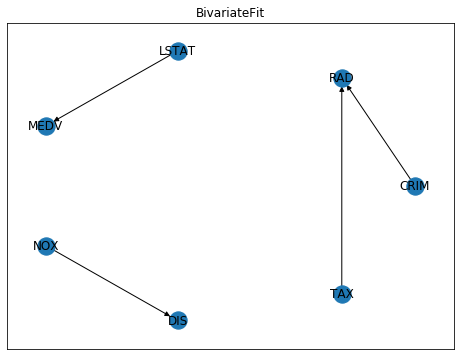

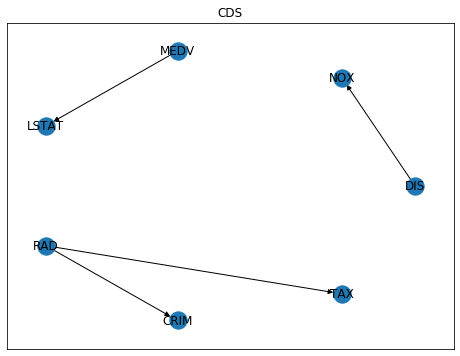

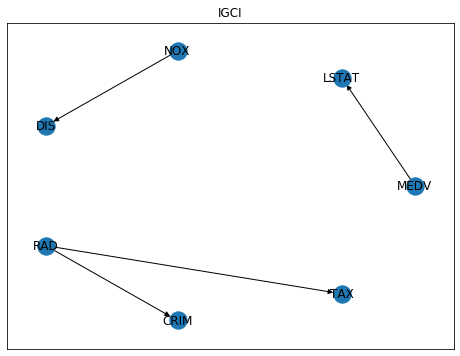

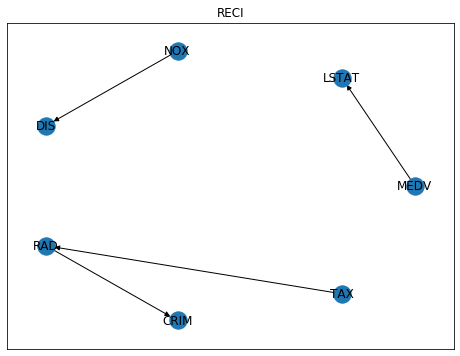

In [30]:
from cdt.causality.pairwise import *
def test_pairwise_model(mymodel):
    obj = mymodel()
    graph = obj.orient_graph(df_features.join(df_target), nx.DiGraph(ugraph))
    sorted_graph = nx.DiGraph()
    sorted_graph.add_edges_from(sorted(graph.edges()))
    pos = nx.drawing.layout.circular_layout(sorted_graph)

    plt.figure(0,figsize=(8,6)) 
    nx.draw_networkx(sorted_graph,pos)
    plt.title(mymodel.__name__)
    plt.show()
    
for mymodel in [BivariateFit, CDS, IGCI, RECI]:
    test_pairwise_model(mymodel)